|                    ?                |                 ?                   |                  ?                  |
| ----------------------------------- | ----------------------------------- | ----------------------------------- |
<img src="Adelie.jpg" width="33%" height="33%"> <img src="Chinstrap.jpg" width="33%" height="33%"> <img src="Gentoo.jpg" width="33%" height="33%">

# Penguin Analysis: Part III
#### K-means clustering model

*Purpose*\
To provide insights into the underlying structure within the penguin dataset and confirm if a clustering by sex and species is most expedient.

*Deliverables for Part III*     
This notebook contains a K-means clustering model built to identify patterns in the penguin data. These patterns will confirm if there is a standard set of measurements specific to each species. 
> K-means clustering is an unsupervised partitioning algorithm which clusters unlabeled data. It does this by creating a logical scheme to make sense of that data. K-means works by defining each cluster around a central point (centroid) that is determined by the mean of all points in the cluster. K-means can find patterns not already recognized or confirm those which have been. The identified patterns will confirm the body mass predictions made by the regression models providing further security that they are reliant. Reliant body mass predications mean proper care taking of the penguins can take place with confidence.

*Data*\
This project uses the Palmer Penguins data set collected and made available by Dr. Kristen Gorman and PalmerStation, Antarctica, LTER. The data is available at: https://allisonhorst.github.io/palmerpenguins. Here it was accessed through the seaborn library. For this activity, species identification is removed from the observations.

*Code*\
All code for this project is located at: https://github.com/izsolnay/Penguins_Python

*Report*\
The report for this project is located at: https://github.com/izsolnay/Penguins_Python

# K-means clustering

In [1]:
# Import standard operational packages.
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')

# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from gap_statistic import OptimalK

# Import visualization packages.
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data; create df
df0 = pd.read_csv('Penguins_clean.csv')
df0.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


## PART I: EDA, check and prepare data for clustering
* check for missing values: assumption of k-means is no missing values
* drop unneeded variables
* encode data: K-means needs numeric columns for clustering
  * encode `sex`
  * do not encode `species` or `island` because they will not be used in model 
* any scaling: groups need to be scaled (see below)

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            335 non-null    object 
 1   island             335 non-null    object 
 2   bill_length_mm     335 non-null    float64
 3   bill_depth_mm      335 non-null    float64
 4   flipper_length_mm  335 non-null    float64
 5   body_mass_g        335 non-null    float64
 6   sex                335 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.4+ KB


In [4]:
df0.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,335.000000,335.000000,335.000000,335.000000
mean,43.856418,17.132239,200.937313,4200.895522
std,5.312037,1.977896,13.981348,800.962616
min,32.100000,13.100000,172.000000,2700.000000
25%,39.250000,15.500000,190.000000,3550.000000
50%,44.400000,17.300000,197.000000,4050.000000
75%,48.450000,18.700000,213.000000,4750.000000
max,55.900000,21.500000,231.000000,6300.000000


In [5]:
# Investigate species for later comparisons
df0['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [6]:
# Investigate sex for later comparisons
df0['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [7]:
# Get balances for each species
df0['species'].value_counts()
df0['species'].value_counts(dropna = False)

species
Adelie       148
Gentoo       121
Chinstrap     66
Name: count, dtype: int64

In [8]:
# Get balances for each sex
df0['sex'].value_counts()
df0['sex'].value_counts(dropna = False)

sex
Female    168
Male      167
Name: count, dtype: int64

In [9]:
# Check for missing values
df0.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [10]:
# Drop for missing values
df = df0.dropna(axis=0).reset_index(drop = True)

In [11]:
# Check that it worked
df.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            335 non-null    object 
 1   island             335 non-null    object 
 2   bill_length_mm     335 non-null    float64
 3   bill_depth_mm      335 non-null    float64
 4   flipper_length_mm  335 non-null    float64
 5   body_mass_g        335 non-null    float64
 6   sex                335 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.4+ KB


#### Check for outliers

In [13]:
# Drop island variable, because model is clustering based on body features
penguins = df.drop(['island'], axis=1)

In [14]:
# Clean sex column entries to all uppercase
penguins['sex'] = penguins['sex'].str.upper()

In [15]:
# Encode variable 'sex' because object
penguins = pd.get_dummies(penguins, drop_first = True, columns=['sex'])

In [16]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            335 non-null    object 
 1   bill_length_mm     335 non-null    float64
 2   bill_depth_mm      335 non-null    float64
 3   flipper_length_mm  335 non-null    float64
 4   body_mass_g        335 non-null    float64
 5   sex_MALE           335 non-null    bool   
dtypes: bool(1), float64(4), object(1)
memory usage: 13.5+ KB


### Scale features
Although this project does not assume knowledge of the 3 species represented in the data set, it is known that Chinstrap penguins account for a smaller portion of penguins in the data set. Because they are less common and therefore in the minority, this will likely affect the K-means clustering since it performs best with similar sized groupings.

It is also important to scale because K-means clustering uses distance between observations as its measure of similarity. Different measurement types (for example meters vs grams) could result in significant differences represented as small numbers and minor differences as much larger numbers. By using StandardScaler all variables will have a mean of 0 and variance/standard deviation of 1.

In [17]:
# Subset X variable, drop species as it's what is trying to be identified
X = penguins.drop(['species'], axis=1)

# Pass data to fit.transform() function
X_scaled = StandardScaler().fit_transform(X)
X_scaled[:2,:]

array([[-0.89674321,  0.79382669, -1.42812676, -0.56378413,  1.00298954],
       [-0.82132988,  0.13557931, -1.0699725 , -0.50126586, -0.99701937]])

### Start modeling
* instantiate model (kmeans3 = KMeans(n_clusters=3, random_state=42))
  * use 3 clusters as first attempt
* compare the inertias of multiple K values 
  * fit K-means to return a model object that has "learned" the data
      * evaluate inertia for different values of k
      * location of centroids
      * class labels
  * write a function called kmeans_inertia that
    * takes in num_clusters and x_vals
    * returns a list of each k-value's inertia

In [18]:
# Instantiate model
kmeans3 = KMeans(n_clusters=3, random_state=42)

In [19]:
# Fit model to data
kmeans3.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

### EVALUATION
Good clustering:    
* identifiable clusters
* within each cluster (**intra-cluster**) = points are close to each other
  * $inertia$ gauges how closely related each observation is to the other observations in its own cluster
  * $inertia$ is the sum of the squared distances between each observation and its nearest centroid
  * $inertia$ should be as close to 0 as possible
* between the clusters (**inter-cluster**) = lots of *empty space* 

In [20]:
# Call .labels_ attribute to return a list of cluster assignments
# 3 clusters = assigned values to each observation are 0, 1, or 2
print('Clusters: ', kmeans3.labels_)

# Call .inertia_ attribute to return sum of the squared distances of samples from their closest cluster center
print('Inertia: ', kmeans3.inertia_)

Clusters:  [0 2 2 2 0 2 0 0 2 2 0 0 2 2 0 2 0 2 0 2 0 0 2 0 2 2 0 2 0 2 0 2 0 0 2 2 0
 2 0 2 0 2 0 0 2 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2
 0 2 0 2 0 2 0 2 0 0 2 0 2 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0
 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 0 2 2 0 2 0
 2 0 0 2 0 2 2 0 2 0 2 0 2 0 2 0 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 0 2 2 0
 2 0 0 2 0 2 2 0 2 0 0 2 2 0 2 0 2 0 2 0 0 2 0 2 2 2 0 0 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Inertia:  571.2995770594428


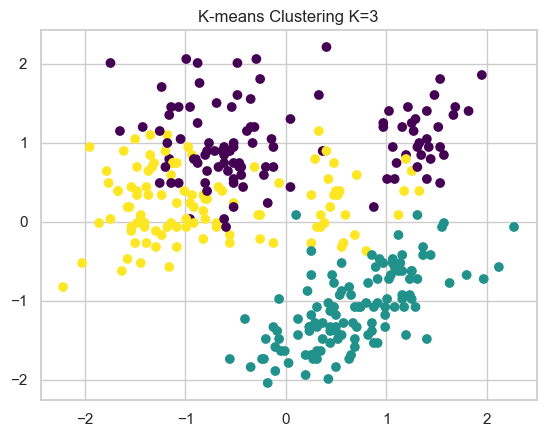

In [21]:
# Plot first attempt with scatterplot
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans3.labels_, cmap='viridis') # cmap = sets colors
plt.title('K-means Clustering K=3')
plt.show()

Results  
3 clusters isn't great
* create function to compare inertias of multiple K values
* find # of clusters by examining inertia values for different values of k   

In [22]:
# Create function to compare inertias of multiple K values                                                                                                                      
num_clusters = [i for i in range(2, 11)]               # generate a list starting from 2 up to 10 (inclusive)

def kmeans_inertia(num_clusters, X_vals):

    inertia = []
    for num in num_clusters:                          # Create iterative for loop
        kms = KMeans(n_clusters=num, random_state=42) # Different k values to try
        kms.fit(X_vals)                               # Training data
        inertia.append(kms.inertia_)                  # A list of inertia scores, 1 for each value of k

    return inertia

In [23]:
# Call function
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

[882.9335591311493,
 571.2995770594428,
 376.8267075583487,
 277.6024594276294,
 209.65983912770113,
 192.96312743036583,
 181.70905052242432,
 171.0730968885082,
 156.69146848329484]

#### Visualize values with elbow plot
* X-axis = various possible K values
* y-axis = inertia

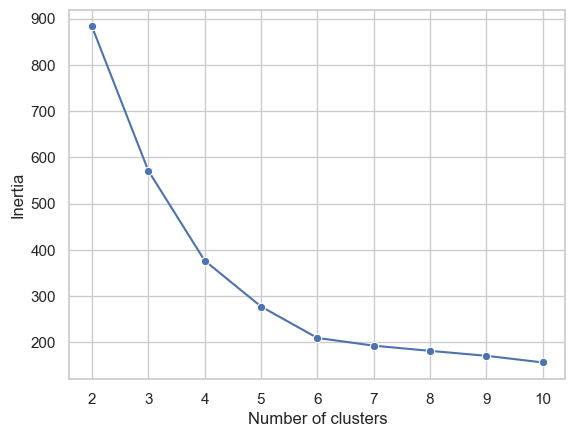

In [24]:
# Create line plot to show the relationship between number of clusters and inertia
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o') # marker = sets marker style
plot.set_xlabel('Number of clusters')
plot.set_ylabel('Inertia')
plt.grid(True);

Results \
Point where the reduction in inertia when a new cluster is added is the *elbow* 
 * The 2nd in list is 571.2995770594428= 3 clusters, definitely not the best

The plot does not contain an unambiguous elbow. There is a point at 4 & 5 clusters, but a more distinct *elbow* is at 6 clusters. This means that models with more than 6 clusters might reduce inertia. The original guess of 3 was likely insufficient.

#### Get silhouette score
**silhouette score** is the mean of the silhouette coefficients of all the observations in the model
* silhouette coefficient can be between -1 and 1
  * close to 1 = within its own cluster and separated from other clusters
  * close to 0 = samples are on or very close to the decision boundary between 2 neighboring clusters = not a lot of space

* compare silhouette score of each value of k, from 2 through 10
  * call silhouette_score() function and pass to it 2 required parameters
    * training data (X_scaled)
    * assigned cluster labels to training data (kmeans3.labels_)
* perform a comparison that compares the silhouette score of each value of k, from 2 through 10.
  * write function that returns a list of each k-value's silhouette score
    * num_clusters
    * X_vals
  * calculate silhouette scores for k=2-10

In [25]:
# Get silhouette score for kmeans3 model
kmeans3_sil_score = silhouette_score(X_scaled, kmeans3.labels_)
kmeans3_sil_score

0.45597569338010185

In [26]:
# Write a function to iterate over each number of clusters to get silhouette scores
def kmeans_sil(num_clusters, x_vals):      # list of number of clusters to test
                                           # x_vals is data to cluster.
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)             # Fits model where k = each value in the list of ints
        sil_score.append(silhouette_score(x_vals, kms.labels_))  # Calculates a silhouette score for each k value
                                                                 # Appends each score to a list

    return sil_score

In [27]:
# Call function, get list of scores
print('Silhouette scores for k=2-10:')
sil_score = kmeans_sil(num_clusters, X_scaled)

for i, score in zip(range(2, 11), sil_score):
    print(f'# of clusters: {i}, Silhouette score score: {score}')

Silhouette scores for k=2-10:
# of clusters: 2, Silhouette score score: 0.4464916565029188
# of clusters: 3, Silhouette score score: 0.45597569338010185
# of clusters: 4, Silhouette score score: 0.5131539758666861
# of clusters: 5, Silhouette score score: 0.5238162936931439
# of clusters: 6, Silhouette score score: 0.5271813454904477
# of clusters: 7, Silhouette score score: 0.47848307330207374
# of clusters: 8, Silhouette score score: 0.42002368523568945
# of clusters: 9, Silhouette score score: 0.4215709637881699
# of clusters: 10, Silhouette score score: 0.3656343709208427


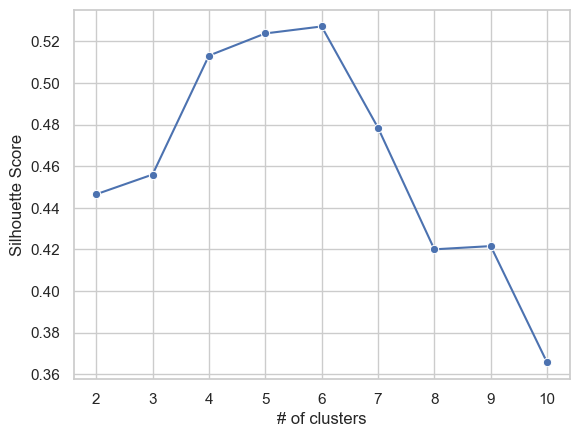

In [28]:
# Create a line plotting the relationship between num_clusters and sil_score
plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel('# of clusters')
plot.set_ylabel('Silhouette Score')
plt.grid(True);

Results \
The closest silhouette score to 1 (within its own cluster and separated from other clusters) is at 6 clusters (0.5271813454904477).\
This can be seem on the plot, although 5 clusters is close in score.\
This confirms the inertia elbow at k=6.

#### Validate k=6 with Davies-Bouldin Index and Gap Statistics

#### Get Davies-Bouldin Index scores
**Davies-Bouldin Index** evaluates effectiveness of clustering into distinct groups or clusters. It measures how well-separated the clusters are and how compact they are within themselves.

* Davies-Bouldin which is
  * close to 1 = poorly clustered (ill-separated, spread out, and not compact)
  * close to 0 = optimally clustered

In [29]:
# Write a function to iterates over each number of clusters to calculate the Davies-Bouldin
def kmeans_db(num_clusters, x_vals):
    db_score = []
    
    for num in num_clusters:
        kmeans = KMeans(n_clusters=num, random_state=42)
        kmeans.fit(x_vals)
        db_score.append(davies_bouldin_score(x_vals, kmeans.labels_))
    
    return db_score

In [30]:
# Call function, get list of scores
print('Davies-Bouldin Scores:')
db_score = kmeans_db(num_clusters, X_scaled)

for i, score in zip(range(2, 11), db_score):
    print(f'# of clusters: {i}, DB score: {score}')

Davies-Bouldin Scores:
# of clusters: 2, DB score: 0.9666117048782789
# of clusters: 3, DB score: 0.9004751097622595
# of clusters: 4, DB score: 0.7501865069730087
# of clusters: 5, DB score: 0.7196432841250544
# of clusters: 6, DB score: 0.7159389140028006
# of clusters: 7, DB score: 0.9376368528195671
# of clusters: 8, DB score: 1.1288878348642433
# of clusters: 9, DB score: 1.0848315459431523
# of clusters: 10, DB score: 1.1655139004803095


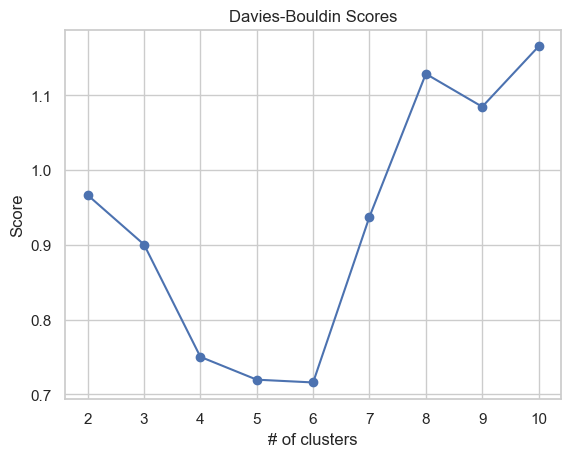

In [31]:
# Plot Davies-Bouldin Scores
plt.figure()
plt.plot(range(2, 11), db_score, marker='o')
plt.title('Davies-Bouldin Scores')
plt.xlabel('# of clusters')
plt.ylabel('Score')
plt.grid(True)
plt.show()

Results \
The plot suggests that a Davies-Bouldin score of 0.7159389140028006 at 6 clusters is best, although not great.\
Because this is still a high score, it suggests that even though it is best there may be some overlap or less distinct separation between the clusters.   

#### Get Gap Statistics number
**Gap Statistics** determines the optimal number of clusters in a dataset. It helps identify the point where adding more clusters does not significantly improve the model's performance.

In [32]:
# Gap Statistics
GapK = OptimalK(parallel_backend='none')
n_clusters = GapK(X_scaled, cluster_array=np.arange(2, 11))
print('Optimal # of Gap Statistics clusters: ', n_clusters)

Optimal # of Gap Statistics clusters:  8


### Refit k-values and evaluate clusters
* instantiate new K-means model with n_clusters=6
* fit model
* print unique labels to see if clustering makes sense
* assign new column to the original unscaled dataframe with the cluster assignment from the final K-means model
* ascertain why model partitions as it did

In [33]:
# Fit a 6-cluster model
kmeans6 = KMeans(n_clusters=6, random_state=42)
kmeans6.fit(X_scaled)

KMeans(n_clusters=6, random_state=42)

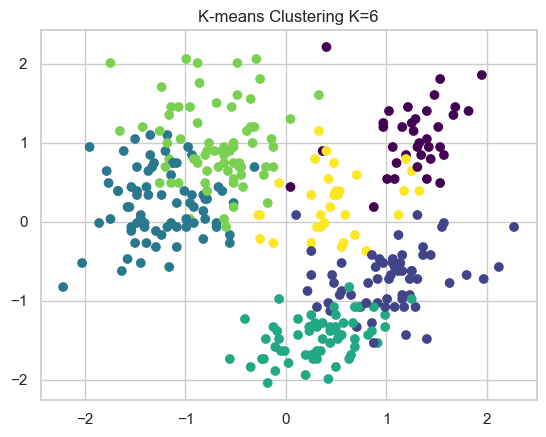

In [34]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans6.labels_, cmap='viridis')
plt.title('K-means Clustering K=6')
plt.show()

Results   
As indicated by the high Davies-Bouldin Index score the K-means6 plot shows overlap and less distinct separation between the clusters. However, the optimal Gap Statistics number, elbow plot, and silhouette scores confirm this is the best configuration.

### Determine how K-means clustering algorithm divided Penguin data set

In [35]:
# Print unique labels
print('Unique labels:', np.unique(kmeans6.labels_))

Unique labels: [0 1 2 3 4 5]


In [36]:
# Set cluster assignment with new feature that indicates cluster assignment in original dataframe 
penguins['cluster'] = kmeans6.labels_
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,cluster
0,Adelie,39.1,18.7,181.0,3750.0,True,4
1,Adelie,39.5,17.4,186.0,3800.0,False,2
2,Adelie,40.3,18.0,195.0,3250.0,False,2
3,Adelie,36.7,19.3,193.0,3450.0,False,2
4,Adelie,39.3,20.6,190.0,3650.0,True,4


In [37]:
# Check if cluster is partitioned by body_mass_g
penguins.groupby(by=['cluster', 'body_mass_g']).size()

cluster  body_mass_g
0        3250.0         1
         3300.0         1
         3400.0         1
         3450.0         1
         3550.0         1
                       ..
5        3800.0         1
         3850.0         1
         3900.0         1
         3950.0         1
         4150.0         1
Length: 164, dtype: int64

In [38]:
# Check if cluster is partitioned by bill_depth_mm
penguins.groupby(by=['cluster', 'bill_depth_mm']).size()

cluster  bill_depth_mm
0        17.5             1
         18.0             1
         18.1             1
         18.2             3
         18.5             1
                         ..
5        18.4             1
         18.6             1
         18.7             2
         18.9             1
         19.4             1
Length: 151, dtype: int64

In [39]:
# Check if cluster is partitioned by species
penguins.groupby(by=['cluster', 'species']).size()

cluster  species  
0        Adelie        3
         Chinstrap    33
1        Gentoo       60
2        Adelie       74
         Chinstrap     1
3        Gentoo       61
4        Adelie       71
5        Chinstrap    32
dtype: int64

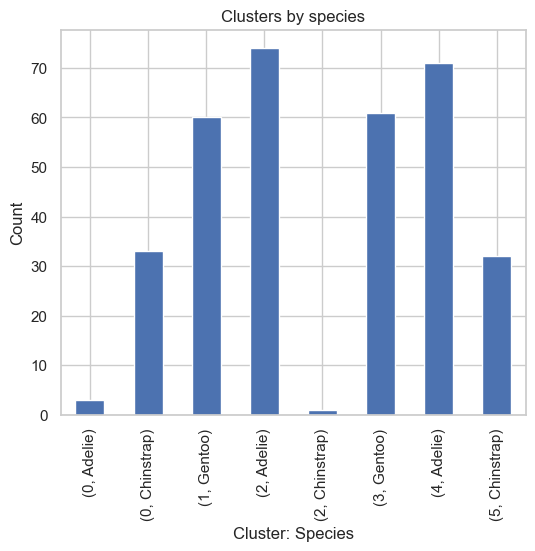

In [40]:
# Visualize clustering by species
penguins.groupby(by=['cluster', 'species']).size().plot.bar(title='Clusters by species', figsize=(6, 5), 
                                                            ylabel='Count', xlabel='Cluster: Species');


Results\
Clusters mostly work by species

In [41]:
# Check clustering by species by sex_MALE
# sex_MALE because pd.get_dummies(penguins, drop_first = True happened to be male
penguins.groupby(by=['cluster','species', 'sex_MALE']).size()

cluster  species    sex_MALE
0        Adelie     True         3
         Chinstrap  True        33
1        Gentoo     True        60
2        Adelie     False       74
         Chinstrap  False        1
3        Gentoo     False       61
4        Adelie     True        71
5        Chinstrap  False       32
dtype: int64

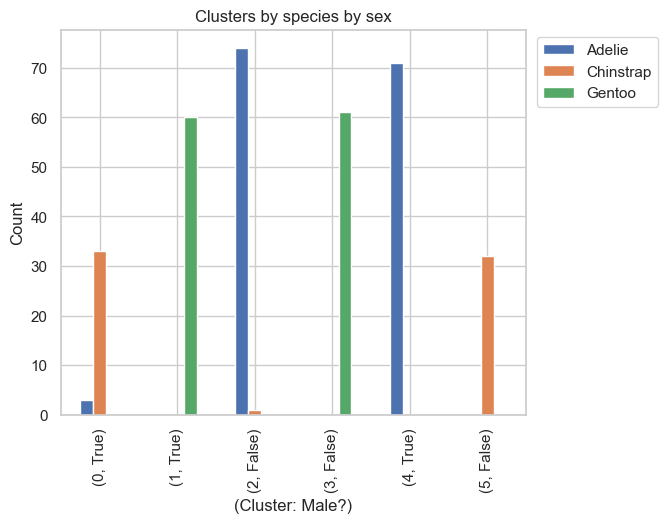

In [42]:
# Visualize clustering by species by sex_MALE 
penguins.groupby(by=['cluster','species','sex_MALE']).size().unstack(level='species', fill_value=0).plot.bar(title='Clusters by species by sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Count',
                                                                                                                      xlabel='(Cluster: Male?)')
plt.legend(bbox_to_anchor=(1.3, 1.0));

In [43]:
# Compare clusters to original cleaned df
df0.groupby('species')['sex'].value_counts()

species    sex   
Adelie     Female    74
           Male      74
Chinstrap  Female    33
           Male      33
Gentoo     Female    61
           Male      60
Name: count, dtype: int64

In [44]:
print(penguins.shape)
df0.shape

(335, 7)


(335, 7)

#### Results     
*Male*
* 0 = Chinstrap
   * there are 33 male Chinstraps in the data set
   * **the model also included 3 male Adelies**
* 1 = Gentoo 60
   * there are 60 male Gentoos in the data set
* 4 = Adelie 71
   * there are 74 male Chinstraps in the data set
   * **missing 3 male Adelies**

*Female*
* 2 = Adelie 74
   * there are 74 female Adelies in the data set
   * **the model also included 1 Chinstrap**
* 3 = Gentoo 61
   * there are 61 female Gentoos in the data set
* 5 = Chinstrap 32
   * there are 33 female Chinstraps in the data set
   * **missing 1 female Chinstraps**
     
The K=mean6 model mostly partitioned the data correctly.
* all sex assignments were correct
* it correctly assigned sex and species to 331 out of 335 observations

  
4 errors:
* the model missed 3 male Adelies
* the model placed the 3 male Adelies it missed in with the male Chinstraps
* the model missed 1 female Chinstrap
* the model placed the 1 female Chinstrap it missed in with the female Adelies

These errors are in keeping with the data. From the extensive EDA, ANOVA, and post hoc testing, it can be confirmed that Chinstraps and Adelies have similar body mass.
